In [1]:
import os

base_dir = 'chest_xray/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_NORMAL_dir = os.path.join(train_dir, 'NORMAL')
train_PNEUMONIA_dir = os.path.join(train_dir, 'PNEUMONIA')

validation_NORMAL_dir = os.path.join(validation_dir, 'NORMAL')
validation_PNEUMONIA_dir = os.path.join(validation_dir, 'PNEUMONIA')

test_NORMAL_dir = os.path.join(test_dir, 'NORMAL')
test_PNEUMONIA_dir = os.path.join(test_dir, 'PNEUMONIA')

train_NORMAL_fnames = os.listdir(train_NORMAL_dir)
train_PNEUMONIA_fnames = os.listdir(train_PNEUMONIA_dir)

validation_NORMAL_fnames = os.listdir(validation_NORMAL_dir)
validation_PNEUMONIA_fnames = os.listdir(validation_PNEUMONIA_dir)

test_NORMAL_fnames = os.listdir(test_NORMAL_dir)
test_PNEUMONIA_fnames = os.listdir(test_PNEUMONIA_dir)

n_train = len(train_NORMAL_fnames) + len(train_PNEUMONIA_fnames)
n_validation = len(validation_NORMAL_fnames) + len(validation_PNEUMONIA_fnames)
n_test = len(test_NORMAL_fnames) + len(test_PNEUMONIA_fnames)

print(n_train, n_validation, n_test)

5216 624 16


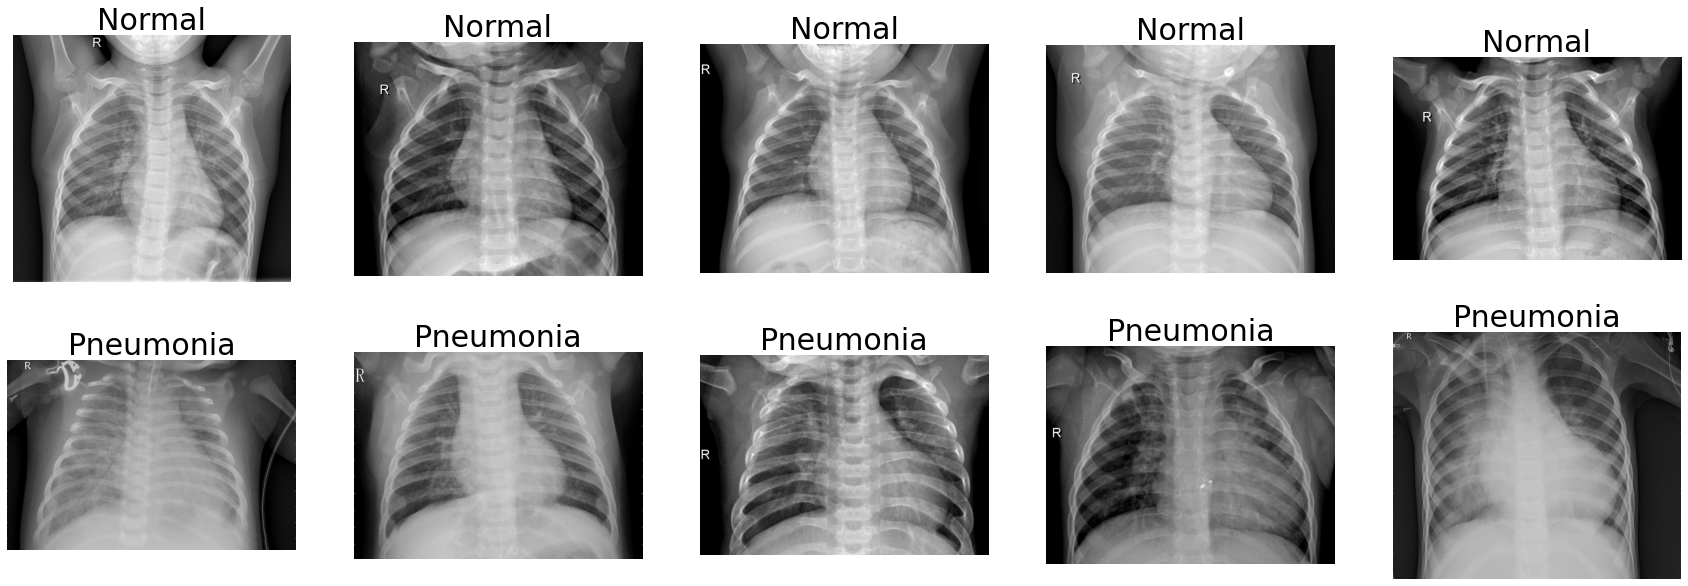

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(0,5):
    img = plt.imread(os.path.join(train_NORMAL_dir, train_NORMAL_fnames[i]))
    ax[0,i].imshow(img, cmap='gray')
    ax[0,i].axis('off')
    ax[0,i].set_title('Normal', fontsize=30)
    
for i in range(0,5):
    img = plt.imread(os.path.join(train_PNEUMONIA_dir, train_PNEUMONIA_fnames[i]))
    ax[1,i].imshow(img, cmap='gray')
    ax[1,i].axis('off')
    ax[1,i].set_title('Pneumonia', fontsize=30)
    
plt.show()
# fig.savefig('charts/x-ray-images.jpg')

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   samplewise_center=True,
                                   samplewise_std_normalization=True,
                                   zoom_range = 0.2, 
                                   width_shift_range=0.1,  
                                   height_shift_range=0.1)

validation_datagen  = ImageDataGenerator(rescale = 1.0/255,
                                         samplewise_center=True,
                                         samplewise_std_normalization=True, 
                                         zoom_range = 0.2, 
                                         width_shift_range=0.1,  
                                         height_shift_range=0.1)

test_datagen  = ImageDataGenerator(rescale = 1.0/255,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=16,
                                                    class_mode='binary',
                                                    target_size=(160, 160))

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              batch_size=16,
                                                              class_mode='binary',
                                                              target_size=(160, 160))

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  class_mode='binary',
                                                  target_size=(160, 160))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential(name='X-ray_CNN')

model.add(tf.keras.layers.InputLayer(input_shape=(160,160,3)))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

METRICS = ['accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')]
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)
model.summary()

Model: "X-ray_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 158, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 158, 158, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 158, 158, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 77, 77, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 77, 77, 64)        0 

In [45]:
history = model.fit(train_generator, 
          steps_per_epoch= n_train//16,
          validation_data=validation_generator,
          epochs=20,
          verbose=1)

Epoch 1/20
326/326 [==============================] - 366s 1s/step - loss: 0.2991 - accuracy: 0.8834 - precision: 0.9105 - recall: 0.9350 - val_loss: 1.6368 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 2/20
326/326 [==============================] - 279s 855ms/step - loss: 0.1780 - accuracy: 0.9289 - precision: 0.9490 - recall: 0.9556 - val_loss: 0.6121 - val_accuracy: 0.7628 - val_precision: 0.7266 - val_recall: 0.9949
Epoch 3/20
326/326 [==============================] - 284s 869ms/step - loss: 0.1598 - accuracy: 0.9377 - precision: 0.9561 - recall: 0.9603 - val_loss: 0.7560 - val_accuracy: 0.7420 - val_precision: 0.7093 - val_recall: 0.9949
Epoch 4/20
326/326 [==============================] - 291s 890ms/step - loss: 0.1463 - accuracy: 0.9442 - precision: 0.9609 - recall: 0.9641 - val_loss: 0.3400 - val_accuracy: 0.8510 - val_precision: 0.9231 - val_recall: 0.8308
Epoch 5/20
326/326 [==============================] - 290s 888ms/step - loss: 0.1392 - accu

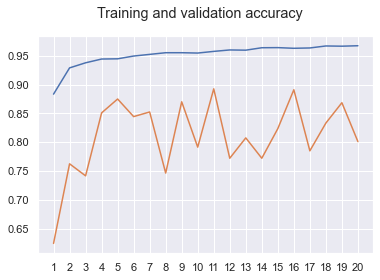

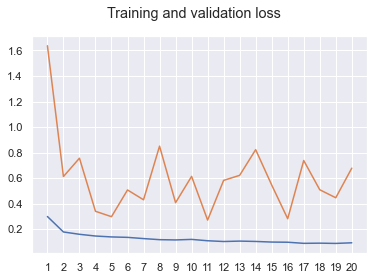

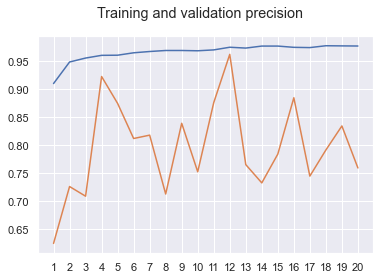

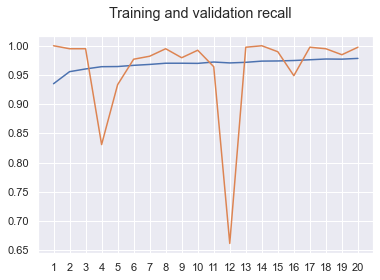

In [7]:
import pandas as ad
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(1, len(acc)+1) 

def metrics_charts(epochs, train_metrics, val_metrics, title):
    fig, axes = plt.subplots()
    axes.plot(epochs, train_metrics)
    axes.plot(epochs, val_metrics)
    axes.set_xticks(np.arange(1, len(epochs)+1))
    fig.suptitle('Training and validation' + ' ' + title)
    return fig

metrics_charts(epochs, acc, val_acc, 'accuracy').savefig('charts/accuracy.jpg')
metrics_charts(epochs, loss, val_loss, 'loss').savefig('charts/loss.jpg')
metrics_charts(epochs, precision, val_precision, 'precision').savefig('charts/precision.jpg')
metrics_charts(epochs, recall, val_recall, 'recall').savefig('charts/recall.jpg')

C:\Users\tsoiy\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<Figure size 432x288 with 0 Axes>

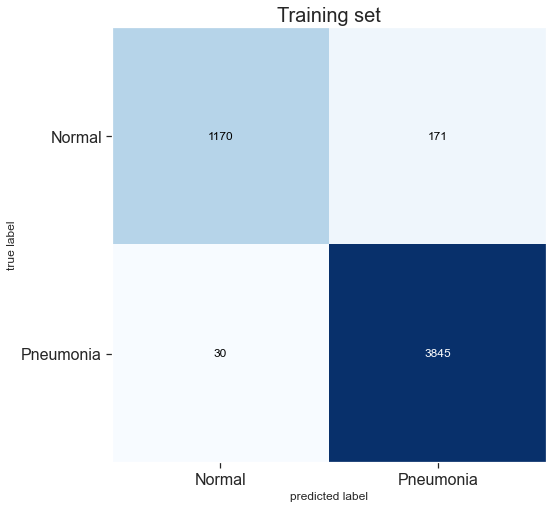

C:\Users\tsoiy\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<Figure size 432x288 with 0 Axes>

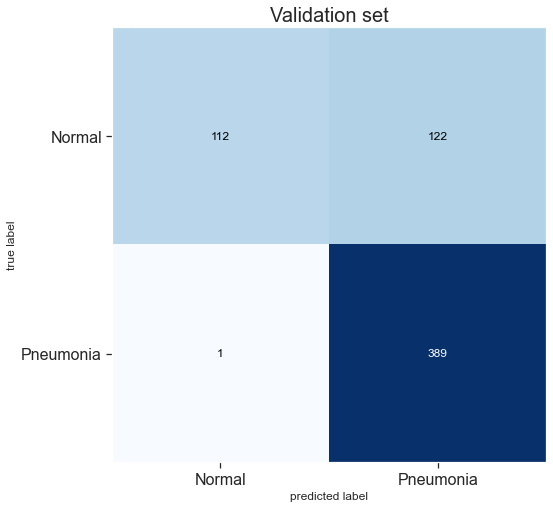

C:\Users\tsoiy\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<Figure size 432x288 with 0 Axes>

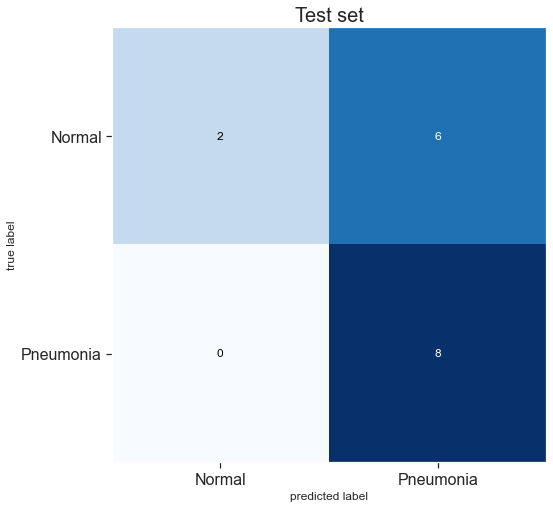

In [8]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

def plot_confusion(n, generator, title):
    labels = []
    for i in range(0, n//16):
        labels.extend(generator[i][1])
    labels = np.array(labels)
    preds = model.predict_classes(generator)
    preds = np.reshape(preds, n)

    cm  = confusion_matrix(labels, preds)
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=False,cmap=plt.cm.Blues)
    plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.title(title, fontsize=20)
    plt.savefig('charts/' + title + ' ' + 'confusion.jpg')
    plt.show()

plot_confusion(n_train, train_generator, 'Training set')
plot_confusion(n_validation, validation_generator, 'Validation set')
plot_confusion(n_test, test_generator, 'Test set')